# FORMATIVE ASSESSMENT OF ADOLESCENT GIRLS AND YOUNG WOMEN’S HIV, GENDER-BASED VIOLENCE AND SEXUAL AND REPRODUCTIVE HEALTH STATUS

## Background
Teenage pregnancy and motherhood have been a major health and social concern in Uganda as it infringes upon the human rights of girls but also hinders their ability to achieve their full socioeconomic development. Teenagers who engage in sexual intercourse at a young age face an elevated risk of becoming pregnant and giving birth. The 2022 UDHS indicated that 23.5% of women age 15-19 had initiated childbearing by the time of the survey, with 18.4% having already had a live birth, while 5.1% were pregnant with their first child.

Patterns by background characteristics:
* By age 16, 1 in every 10 women age 15-19 has begun childbearing. This percentage significantly rises to almost 4 out of every 10 by the time they reach 18 (Table 5.12).
* Teenagers in rural areas started childbearing earlier than those in urban areas. Twenty five percent of women age 15-19 in rural areas have begun childbearing, compared with 21% in urban areas.
* Teenage childbearing varies by region. The percentage of women age 15-19 who have begun childbearing ranges from 15% in Kigezi region to 28 % -30% in Busoga and Bukedi sub regions.
* The proportion of women age 15-19 who have begun childbearing decreases with both education and wealth.

Regions: The selection of the districts that we surveyed was informed by HIV prevalence dynamics and implementing partner support: we went to districts where there were Global Fund-supported implementing partners working to reduce the new number of new HIV infections among AGYW, improve SRH (e.g. reduce teenage pregnancy) and GBV indicators in the targeted districts.

## Data Processing

The output of this notebook includes four cleaned data frames, ready for further analysis.

## Load data

In [3]:
# Import libraries
import warnings
import os
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/teenage_pregnancy')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/teenage_pregnancy


## Data quality and description

In [5]:
# Load the Stata file (.dta)
df_load = pd.read_stata("./data/AGYW_dataset_for_UNICEF.dta")

df_load.columns = df_load.columns.str.lower() # standardize columns

df_load = df_load.dropna(axis=1, how='all') # drop null columns
df_load = df_load.drop(columns=df_load.loc[:, 'force_threat':'useful_item'].columns)
df_load = df_load.drop(columns=['continues', 'district_code'])
df_load = df_load.dropna(subset=['been_preg'])

df_load.head()

,uniquekey,part_number,school_name,date,scol_status,scol_own,scol_location,locate_other,scol_level,born_month,...,hivresult,regionstudy,regionubos,agegroup,syphilis,district,pop_nf_1024,sam_nf_1024,pon_nfagegrp,sam_nfagegrp
0,358,01128,ABARLER P/S (01),2018-08-07 00:00:00,In school,1.00,2.00,,1.00,10.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
1,466,01150,ABERLER PRIMARY SCHOOL (01),2018-08-07 00:00:00,In school,1.00,2.00,,1.00,10.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
2,385,01135,ABALER PRIMARY SCHOOL(01),2018-08-07 00:00:00,In school,1.00,2.00,,1.00,7.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
3,381,01350,,2018-08-15 00:00:00,Out of school,NaN,NaN,,4.00,98.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
4,456,01124,ABERLER PRIMARY SCHOOL (01),2018-08-07 00:00:00,In school,1.00,1.00,,1.00,5.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59


In [6]:
total = df_load['been_preg'].shape[0]
count = (df_load['been_preg'] == 1).sum()
print(f"The raw dataset contains responses from {total} girls (10-24) of which {count} have been pregnancy.")

The raw dataset contains responses from 8076 girls (10-24) of which 2345 have been pregnancy.


## Recoding

Q.1001 Have you ever been pregnant and gave birth to a baby? [been_preg]

Q.401 Have you ever had any sexual intercourse in your life? (By this, I mean when a man or boy puts his penis in a woman or girl’s vagina) [life_sex]

Q.405 The first time you had sexual intercourse with someone; would you say you were willing, somewhat willing or not willing at all? Willing means you gave permission or said it was OK or that you did it because you wanted to and not because someone forced you to do it [will_sex]

In [9]:
df_clean = df_load.copy()

# Been pregnant (1 = Yes, 0 = No) [1001]
df_clean['been_preg'] = df_clean['been_preg'].map({1.0: 1, 2.0: 0}).astype(int)

# Life sex (1 = Yes, 0 = No) [401]
df_clean['life_sex'] = df_clean['life_sex'].map({1.0: 1, 2.0: 0}).fillna(-1).astype(int) # fill na with -1 for now

# life_sex (correcting erorrs where life_sex is coded as -1)
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['life_sex'] == -1), 'life_sex'] = 1
df_clean.loc[(df_clean['been_preg'] == 0) & (df_clean['life_sex'] == -1), 'life_sex'] = 0
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['life_sex'] == 0), 'life_sex'] = 1

# Willingness to have sex [405]
df_clean['will_sex_binary'] = df_clean['will_sex'].map({1.0: 1, # very willing
                                                        2.0: 1, # somewhat willing
                                                        3.0: 0, # not willing at all
                                                        4.0: 0}) # don't know

# Did you or your partner do anything to prevent pregnancy? [406]
df_clean['do_anything_binary'] = df_clean['do_anything'].map({1.0: 1, # yes
                                                        2.0: 0, # no
                                                        3.0: np.nan}) # don't remember

# Were you under the influence of alcohol or drugs? [408]
df_clean['under_influe_binary'] = df_clean['under_influe'].map({1.0: 1, # yes
                                                        2.0: 0, # no
                                                        3.0: np.nan}) # don't remember

Q.403 Which person did you have sex with for the first time? [person_sex]

In [11]:
# Recategorize
def classify_partner(x):
    if x == 1:
        return 'boyfriend'
    elif x == 2:
        return 'husband'
    elif x >= 3:
        return 'other'
    else:
        return np.nan

df_clean['person_sex_group'] = df_clean['person_sex'].apply(classify_partner)

# Convert it to a categorical variable
df_clean['person_sex_group'] = pd.Categorical(
    df_clean['person_sex_group'],
    categories=['boyfriend', 'husband', 'other'],
    ordered=False
)

# Check the distribution
df_clean['person_sex_group'].value_counts()

person_sex_group
boyfriend    3765
husband       476
other         145
Name: count, dtype: int64

Q.409 When was the last time you had sexual intercourse? [last_sex]

Q.411 In the past 12 months, how often did you use condoms with all these partners? [often_usecondom]

Q.414 Thinking of THE LAST TIME you had intercourse with this partner, did you (or your partner) use a condom? [partuse_condom]

Q.415 Thinking of all the times you had intercourse with this partner IN THE LAST 12 MONTHS, would you say you used a condom all the time, sometimes, or never? [some_times]

Q.416b Some people are worried about pregnancy. How concerned are you or were you about getting pregnant? [worry_preg]

In [13]:
# Order condom use last 12 months as 1 (Never), 2 (Sometimes), 3 (Always) [414]
df_clean.loc[df_clean['some_times'].isin([4, 98]), 'some_times'] = np.nan
df_clean['some_times'] = pd.to_numeric(df_clean['some_times'])

# For pregnancy concern [416b]
df_clean.loc[df_clean['worry_preg'].isin([98]), 'worry_preg'] = np.nan
df_clean['worry_preg'] = pd.to_numeric(df_clean['worry_preg'])
# reverse code higher values indicate greater concern (range from 1 to 4)
df_clean['worry_preg_reverse'] = 5 - df_clean['worry_preg'] 

# For condom use at last sex [414]
df_clean['partuse_condom_binary'] = np.where(df_clean['partuse_condom'] == 1, 1, 0)

In [14]:
# 1003 How did the first pregnancy end? [preg_end]

# 1011 Have you ever had a abortion? [had_abort]

# 1015 Was your most recent abortion spontaneous or induced by you? [???]


Q.intro SCHOOLING STATUS: 1…… IN-SCHOOL 2 ……. OUT OF SCHOOL [scol_status]

Q.103a Have you ever attended school? [atttend_scol]

Q.104c What are some of the main reasons you are not in school? (Select all that apply)

In [16]:
# If not in school and attend school is blank replace with never attended school [Intro Q]
df_clean.loc[(df_clean['scol_status'] == 'Out of school') & (df_clean['attend_scol'].isna()), 'attend_scol'] = 'No'

# Have you ever attended school? [103a]
df_clean['attend_scol_binary'] = df_clean['attend_scol'].map({'Yes':1,'No':0})

# Reasons for drop out [104c]
columns_to_encode = ['lack_fees', 'got_preg', 'got_married', 'got_sick', 'need_money', 'good_std', 'int_scol']
df_clean[columns_to_encode] = df_clean[columns_to_encode].fillna(0)
df_clean[columns_to_encode] = df_clean[columns_to_encode].map(lambda x: 1 if x == 1 else 0)

Q.107a Are you currently married? (by marriage I mean religious, traditional, civil or consensual union) [current_married]

In [18]:
# Marital status to binary numeric (1 = Married, 0 = Never Married) [107a]
df_clean['current_married_binary'] = df_clean['current_married'].map({
    'MARRIED/UNION': 1,
    'DIVORCED/SEPARATED':0,
    'WIDOWED':0,
    'NEVER MARRIED': 0,
    'IN RELATIONSHIP BUT NOT MARRIED': 0
})

# Marital history to binary numeric (1 = Been married, 0 = Never Married) [107a]
df_clean['been_married_binary'] = df_clean['current_married'].map({
    'MARRIED/UNION': 1,
    'DIVORCED/SEPARATED':1,
    'WIDOWED':1,
    'NEVER MARRIED': 0,
    'IN RELATIONSHIP BUT NOT MARRIED': 0
})

Q.1302 How many times have you sought services or information from a doctor or a nurse for these services in the last twelve months? [numb_times]

In [20]:
# Replace 0 with 1 since every individual is assumed to have visited at least once [1302]
df_clean['numb_times'] = df_clean['numb_times'].replace(0, 1)

# Compute the IQR to set an upper bound for outliers
q1 = df_clean['numb_times'].quantile(0.25)
q3 = df_clean['numb_times'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# Cap values above the upper bound to the upper bound value
df_clean['numb_times'] = df_clean['numb_times'].clip(upper=upper_bound)

Q.1101 How old were you when you first got married? [age_marry]

In [22]:
# Compute the IQR for age_marry
q1 = df_clean['age_marry'].quantile(0.25)
q3 = df_clean['age_marry'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower bound
lower_bound = q1 - 1.5 * iqr

# Cap values below the lower bound to the lower_bound value
df_clean['age_marry'] = df_clean['age_marry'].clip(lower=lower_bound)

Q.101 In what month and year were you born? [born_month]

Q.102 How old were you at your last birthday? [age_completed]

In [24]:
# If born_year is missing, estimate it using age_completed
df_clean.loc[df_clean['born_year'].isna(), 'born_year'] = 2018 - df_clean['age_completed']

# If born_month is missing, assume July as the midpoint of the year
df_clean.loc[df_clean['born_month'].isna(), 'born_month'] = 7

# Ensuring numeric dtypes
df_clean['born_month'] = pd.to_numeric(df_clean['born_month'], errors='coerce')  # Convert to numeric, set errors to NaN
df_clean['born_year'] = pd.to_numeric(df_clean['born_year'], errors='coerce')  # Convert to numeric

# Fix `born_month`: Keep only values between 1 and 12, replace others with NaN
df_clean.loc[~df_clean['born_month'].between(1, 12), 'born_month'] = np.nan

# Fix `born_year`: Keep only reasonable values (between 1993 and 2008)
df_clean.loc[~df_clean['born_year'].between(1993, 2008), 'born_year'] = np.nan

# Assume missing `born_month` is July (middle of the year)
df_clean['born_month'] = df_clean['born_month'].fillna(7)

# Calculate exact months lived by July 2018
df_clean['age_months'] = (2018 - df_clean['born_year']) * 12 + (7 - df_clean['born_month'])

# Making sure that the pregnancy age is between 10 and 24
df_clean.loc[~df_clean['age_preg'].between(10, 24), 'age_preg'] = np.nan

# Missing age_preg is replaced with current age minus 1 year
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['age_preg'].isna()), 'age_preg'] = df_clean['age_completed'] - 1

Q.402 How old were you when you had sexual intercourse for the very first time? [age_sex]

Q.1001 Have you ever been pregnant and gave birth to a baby? [been_preg]

Q.102 How old were you at your last birthday? [age_completed]

Q.1101 How old were you when you first got married? [age_marry]

Q.101 In what month and year were you born? [born_month]

In [26]:
# 1. Update 'been_preg' based on 'age_preg'
df_clean.loc[(df_clean['been_preg'] == 0) & (df_clean['age_preg'].notna()), 'been_preg'] = 1

# 2. Validate 'sex_age'
df_clean.loc[~df_clean['sex_age'].between(5, 24), 'sex_age'] = np.nan

# 3. Assign 'sex_age' where missing for pregnant individuals
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['sex_age'].isna()), 'sex_age'] = df_clean['age_preg']

# 4. Ensure 'sex_age' ≥ 'age_preg'
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['sex_age'] > df_clean['age_preg']), 'sex_age'] = df_clean['age_preg']

# 5. Ensure 'age_preg' ≤ 'age_completed'
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['age_preg'] > df_clean['age_completed']), 'age_preg'] = df_clean['age_completed']

# 6. Ensure that 'age_marry' ≤ 'age_completed'
df_clean.loc[(df_clean['age_marry'] > df_clean['age_completed']), 'age_marry'] = df_clean['age_completed']

# 7. Update 'age_marry' based on 'been_married'
df_clean.loc[(df_clean['been_married_binary'] == 0) & (df_clean['age_marry'].notna()), 'age_marry'] = np.nan

# 8. Remove invalid 'age_preg' entries
df_clean = df_clean[(df_clean['age_preg'].isna()) | (df_clean['age_preg'] <= 25)].copy()

# 9. Calculate 'diff'
df_clean.loc[df_clean['been_preg'] == 1, 'diff'] = (df_clean['age_months'] / 12) - df_clean['age_preg']

# 10. Handle negative 'diff' values
df_clean.loc[df_clean['diff'] < -0.5, 'diff'] = np.nan

### Sample sizes for different subsetting

1. Sample 1 undercounts pregnancy events by excluding women who got pregnant as teens but are now older.
2. Sample 2 includes all teenage pregnancies (good), but compares them to girls who are still in the risk window—some of whom might yet become pregnant (so there’s censoring).
3. Sample 3 compares all teenage pregnancies to women who have passed through the risk window without becoming pregnant. This eliminates right‑censoring and gives a non‑pregnant group whose “at‑risk” period is complete.

In [28]:
# Not been pregnant (currently 10-19) | Been pregnant (currently 10-19)
df_sample_1 = df_clean.loc[(df_clean['age_completed'] <= 19)]
df_sample_1.been_preg.value_counts()

been_preg
0    4216
1     629
Name: count, dtype: int64

In [29]:
# Not been pregnant (currently 10-19) | Been pregnant 10-19 (irrespective of current age)
df_sample_2 = df_clean.loc[
    ( (df_clean['been_preg'] == 1) & (df_clean['age_preg'] <= 19) )
    |
    ( (df_clean['been_preg'] == 0) & (df_clean['age_completed'] <= 19) )
]

df_sample_2['been_preg'].value_counts()

been_preg
0    4216
1    1925
Name: count, dtype: int64

In [30]:
# Never been pregnant (currently older than 19) | Been pregnant 10-19 (irrespective of current age)
df_sample_3 = df_clean.loc[
    ( (df_clean['been_preg'] == 1) & (df_clean['age_preg'] <= 19) )
    |
    ( (df_clean['been_preg'] == 0) & (df_clean['age_completed'] >= 20) )
]

df_sample_3['been_preg'].value_counts()

been_preg
1    1925
0    1513
Name: count, dtype: int64

## Creating categories

**Marriage before, after, never**

In [33]:
# Marriage before pregnancy [107a]
def marriage_timing(row):
    if pd.isna(row['age_marry']):
        return 'never'
    elif row['age_marry'] > row['age_preg']:
        return 'after'
    else:
        return 'before'

df_clean['marriage_timing'] = df_clean.apply(marriage_timing, axis=1)

print(df_clean['marriage_timing'].value_counts())

marriage_timing
never     6701
before    1129
after      246
Name: count, dtype: int64


The table below shows the count of total girls, pregnancies, and pregnancy rate based on the timing of marriage: before pregnancy, after pregnancy (100% as expected) and never been married. 

In [67]:
# marriage_timing by total girls, pregnancies, and pregnancy rate
summary = (
    df_clean
      .groupby('marriage_timing')['been_preg']
      .agg(
          total_girls = 'count',
          pregnancies  = 'sum',
          preg_rate    = 'mean'
      )
      .reset_index()
)
summary

,marriage_timing,total_girls,pregnancies,preg_rate
0,after,246,246,1.00
1,before,1129,1078,0.95
2,never,6701,1023,0.15


**School Complete**

In Uganda, Universal Primary Education guarantees completion through P7, but many consider completion of lower secondary (O‑Level, S1–S4) as the de facto end of free, guaranteed schooling. Below, school completeness is considered from O-Level, S1-S4.

* in_school = 'in school'
* out_complete = 'out of school' & level >= O-Level
* drop_out = 'out of school' & level < O-level

In [36]:
# Highest level completed
completed = [4, 5, 6, 7, 8, 9]

# Function for in_school, out_completed, drop_out
def classify_school(row, complete_codes):
    if row['scol_status'] == 'In school':
        return 'in_school'
    # out of school:
    if row['highest_educ'] in complete_codes:
        return 'out_completed'
    else:
        return 'drop_out'

# Using O‑Level as the cutoff
df_clean['school_complete'] = df_clean.apply(classify_school, axis=1, 
                               complete_codes=completed)

df_clean['school_complete'].value_counts()

school_complete
in_school        4020
drop_out         3685
out_completed     371
Name: count, dtype: int64

**Dropped out**

In [38]:
df_clean['dropped_out'] = np.where(
    (df_clean['scol_status'] == 'Out of school') & (df_clean['highest_educ'] < 4),
    1,
    0
)

df_clean['dropped_out'].value_counts()

dropped_out
0    7380
1     696
Name: count, dtype: int64

**Household Vulnerability**

Vulnerability was measured at the individual, household and community levels, following the steps outlined in the report entitled, The Adolescent Girls Vulnerability Index: Guiding Strategic Investment in Uganda.

For household level, a girl was considered vulnerable if she experienced any two of the following five conditions: no access to improved source of water, no access to improved sanitation, household head has no education, food insecurity (no access to food in a day), and non-family support (ever consulted others for social support other than a family member).

In [40]:
# Conditions met for HH vulnerability index
df_clean['pre_ques'] = df_clean.loc[:, 'sick_adult':'care_orphan'].apply(lambda row: (row == 1).sum(), axis=1)
df_clean['hh_vul'] = 0  # Default to 0 for all

# Only apply vulnerability conditions if pre_ques > 0
df_clean.loc[df_clean['pre_ques'] > 0, 'hh_vul'] = (
    (
        (df_clean['source_water'] == 3).astype(int) +  # No improved water
        (df_clean['type_toilet'] != 1).astype(int) +  # No improved sanitation
        (df_clean['highest_educ'].isna()).astype(int) +  # Household head has no education (skipped question)
        (df_clean['enough_food'] != 1).astype(int) +  # Food insecurity (at least 1 day without food)
        (df_clean['consult_spirit'] != 1).astype(int)  # Consulted non-family for social support
    ) >= 2  # If at least two conditions are met → Vulnerable (1), otherwise (0)
).astype(int)  # Ensure the column contains only 0s and 1s

# Tabulate population count
hh_vul_count = df_clean.groupby(['hh_vul', 'been_preg']).size().reset_index(name='count')
hh_vul_count['percentage'] = hh_vul_count['count'] / hh_vul_count.groupby('hh_vul')['count'].transform('sum') * 100
hh_vul_count

,hh_vul,been_preg,count,percentage
0,0,0,4852,70.11
1,0,1,2069,29.89
2,1,0,877,75.93
3,1,1,278,24.07


  Wealth Tertile  Count  Percentage
0            Low   2693       33.30
1         Medium   2691       33.30
2           High   2692       33.30


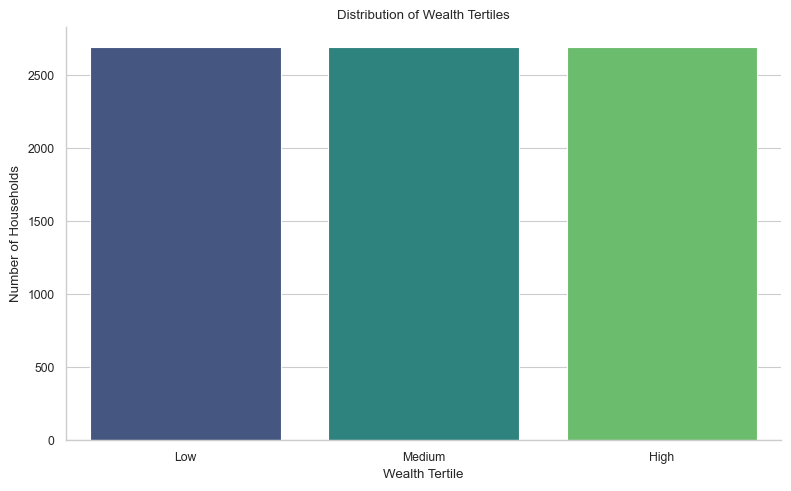

tv_set         0.41
electricity    0.38
run_water      0.37
bath_room      0.36
car            0.32
income_busin   0.28
computer       0.22
motorcycle     0.21
radio          0.20
cell_phone     0.20
reg_phone      0.15
generator      0.13
solar          0.11
own_home       0.09
bicycle        0.09
dtype: float64


In [41]:
# Wealth quintiles
asset_vars = ['radio',
              'tv_set',
              'bicycle',
              'motorcycle',
              'own_home',
              'cell_phone',
              'reg_phone',
              'computer',
              'income_busin',
              'bath_room',
              'run_water',
              'electricity',
              'car',
              'generator',
              'solar'
             ]

# Handle categorical responses: Replace '98' with NaN and convert to binary
df_assets = df_clean[asset_vars].replace(98, np.nan).copy()
df_assets = df_assets.map(lambda x: 1 if x == 1 else 0)

# Fill NaN with 0 (assuming lack of asset ownership if unsure)
df_assets = df_assets.fillna(0)

# Standardize the data
scaler = StandardScaler()
assets_scaled = scaler.fit_transform(df_assets)

# Apply PCA
pca = PCA(n_components=1)
wealth_index = pca.fit_transform(assets_scaled)

# Assign the first principal component as a flat array
df_clean['wealth_index'] = wealth_index[:, 0]

# Create wealth tertiles
df_clean['wealth_tertile'] = pd.qcut(df_clean['wealth_index'], 3, labels=['Low', 'Medium', 'High'])

df_clean['wealth_tertile'] = pd.Categorical(
    df_clean['wealth_tertile'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

# Summary table
wealth_summary = df_clean['wealth_tertile'].value_counts().sort_index().reset_index()
wealth_summary.columns = ['Wealth Tertile', 'Count']
wealth_summary['Percentage'] = (wealth_summary['Count'] / wealth_summary['Count'].sum() * 100).round(1)

print(wealth_summary)

# Visualize the Wealth Tertiles
plt.figure(figsize=(8, 5))
sns.countplot(x='wealth_tertile', data=df_clean, palette="viridis", hue='wealth_tertile')
plt.xlabel("Wealth Tertile")
plt.ylabel("Number of Households")
plt.title("Distribution of Wealth Tertiles")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('wealth_tertiles.png', dpi=300)
plt.show()

# Display PCA weights
wealth_weights = pd.Series(pca.components_[0], index=asset_vars)
print(wealth_weights.sort_values(ascending=False))

## Export

In [43]:
# Export as csv
df_clean.to_csv('./data/processed_df.csv', index=False)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8235
Columns: 600 entries, uniquekey to wealth_tertile
dtypes: category(25), float32(33), float64(438), int16(4), int32(2), int64(15), int8(22), object(61)
memory usage: 33.5+ MB
